# GEODOS data processing

In [314]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [440]:
dto = '/storage/stations/LS/GEODOS/2023/03/27/'
dto = '/storage/stations/LS/GEODOS/2023/05/30/'


df = pd.DataFrame()
  
for fto in glob.iglob(dto + '*'): # generator, search immediate subdirectories 
    l=[]
    l.extend(range(0,1039))
    rdf = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='c',low_memory=False)
    rdf.drop(rdf[(rdf[1]!='$HIST')&(rdf[1]!='$HITS')].index, inplace=True)
    print(fto, rdf[(rdf[1]!='$HIST')].shape[0],rdf[(rdf[1]!='$HIST')].shape[0])
    df = pd.concat([df, rdf])
    
    
#df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
#df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

#df.drop(df[(df[1]!='$HIST')&(df[1]!='$HITS')].index, inplace=True)

print('end')

/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_22 286 286
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_10 284 284
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_03 285 285
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_09 281 281
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_04 285 285
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_17 283 283
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_21 285 285
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_13 284 284
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_19 285 285
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_00 280 280
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_07 283 283
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_14 285 285
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_16 278 278
/storage/stations/LS/GEODOS/2023/05/30/geodos.csv.2023-05-30_05 

In [441]:
START_HIST = 12 # Sloupec prvniho kanalu HIST
FIRST_CH = 17  # Sloupec prvniho kanalu bez sumu
LAST_CH = 36+1 # Sloupec posledni kanalu HIST

hist = df.loc[df[1]=='$HIST'].iloc[:,FIRST_CH:LAST_CH]
hist['time'] = df.loc[df[1]=='$HIST'].iloc[:,0]
hist['time'] = pd.to_datetime(hist['time'], unit='s')

hist['temperature'] = df.loc[df[1]=='$HIST'].iloc[:,6]
hist['pressure'] = df.loc[df[1]=='$HIST'].iloc[:,5]
hist['voltage'] = df.loc[df[1]=='$HIST'].iloc[:,7]
hist['current'] = df.loc[df[1]=='$HIST'].iloc[:,8]

hist.reset_index(inplace=True,drop=True)
#hist.set_index('time', drop=False, inplace=True)


## Add individual events to histogram

In [442]:
hits = df.loc[df[1]=='$HITS'].copy()
hits.iloc[:,2:] = hits.iloc[:,2:].apply(pd.to_numeric)
hits['time'] = df.loc[df[1]=='$HITS'].iloc[:,0]
hits['time'] = pd.to_datetime(hits['time'], unit='s')
#hits.set_index('time', inplace=True)
hits.reset_index(inplace=True,drop=True)


In [475]:
START_HIST = 12 # Sloupec prvniho kanalu HIST
FIRST_CH = 17  # Sloupec prvniho kanalu bez sumu
LAST_CH = 36+1 # Sloupec posledni kanalu HIST

MAX_CH = 1024

histogram = pd.DataFrame(np.zeros((len(hist), MAX_CH)))
hist.reset_index(drop=True,inplace=True)
histogram.iloc[:,0:LAST_CH-FIRST_CH] = hist.iloc[:,0:LAST_CH-FIRST_CH]

channels_columns = hits.iloc[:, 4::2].fillna(0).astype(int)

row_indices = np.arange(len(hits))
column_indices = channels_columns.values.flatten()

combined_indices = np.repeat(row_indices, len(column_indices)//hits.shape[0]) * MAX_CH + column_indices
histogram_values = np.bincount(combined_indices, minlength=hits.shape[0] * MAX_CH)#hits.shape[0] * channels_columns.shape[1])
histogram_values = histogram_values.reshape(hits.shape[0], MAX_CH)

histogram.iloc[:,(LAST_CH-FIRST_CH):(LAST_CH-FIRST_CH)+MAX_CH-(LAST_CH-START_HIST)] = histogram_values[:,(LAST_CH-START_HIST):]

histogram['temperature'] = hist['temperature'].apply(pd.to_numeric)
histogram['pressure'] = hist['pressure'].apply(pd.to_numeric)
histogram['voltage'] = hist['voltage'].apply(pd.to_numeric)
histogram['current'] = hist['current'].apply(pd.to_numeric)

histogram['time'] = hist['time']
histogram.set_index('time', drop=False, inplace=True);


In [467]:
histogram

,0,1,2,3,4,5,6,7,8,9,...,1095,1096,1097,1098,1099,temperature,pressure,voltage,current,time
time,,,,,,,,,,,,,,,,,,,,,
2023-05-30 22:50:45,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,15.69,743.28,4.16,-55.0,2023-05-30 22:50:45
2023-05-30 22:50:57,3.0,2.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15.63,743.28,4.16,-55.0,2023-05-30 22:50:57
2023-05-30 22:51:10,1.0,3.0,2.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,15.69,743.28,4.16,-55.0,2023-05-30 22:51:10
2023-05-30 22:51:22,2.0,2.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15.69,743.29,4.16,-55.0,2023-05-30 22:51:22
2023-05-30 22:51:35,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,15.69,743.27,4.16,-55.0,2023-05-30 22:51:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-30 13:48:58,2.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,17.00,742.32,4.15,-58.0,2023-05-30 13:48:58
2023-05-30 13:49:10,0.0,3.0,1.0,1.0,2.0,1.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,17.00,742.33,4.15,-58.0,2023-05-30 13:49:10
2023-05-30 13:49:23,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,17.00,742.32,4.14,-60.0,2023-05-30 13:49:23


In [446]:
df

,0,1,2,3,4,5,6,7,8,9,...,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038
0,1685487045,$HIST,1452,299260.77,0.0,743.28,15.69,4.16,-55.0,969.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1685487045,$HITS,6,5298.0,76.0,31033.0,207.0,35494.0,129.0,59096.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1685487057,$HIST,1453,299273.38,0.0,743.28,15.63,4.16,-55.0,969.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1685487057,$HITS,8,20176.0,576.0,27467.0,38.0,30848.0,374.0,42206.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1685487070,$HIST,1454,299285.99,0.0,743.28,15.69,4.16,-55.0,969.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1685454563,$HITS,11,19413.0,29,25532.0,33.0,39923.0,41,44702.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
566,1685454576,$HIST,9901,266792.61,0,742.32,17.0,4.14,-58,962.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
567,1685454576,$HITS,10,1351.0,41,2357.0,754.0,9284.0,314,9521.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
568,1685454588,$HIST,9902,266805.27,0,742.3,17.0,4.15,-58,962.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [447]:

df = pd.DataFrame([[1, 2, 2],[4, 1, 4],[18, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
df = df.fillna(0).astype(int)

mx = 20

histogram = pd.DataFrame(np.zeros((len(df), mx)))

row_indices = np.arange(len(df))
column_indices = df.values.flatten()

combined_indices = np.repeat(row_indices, len(column_indices)//len(df)) * mx + column_indices
histogram_values = np.bincount(combined_indices, minlength=len(df) * mx)
histogram_values = histogram_values.reshape(len(df), mx)

histogram.iloc[:, :] = histogram_values
histogram

ValueError: cannot reshape array of size 59 into shape (3,20)

In [433]:
df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


## Plot Flux

<AxesSubplot:xlabel='time', ylabel='Counts'>

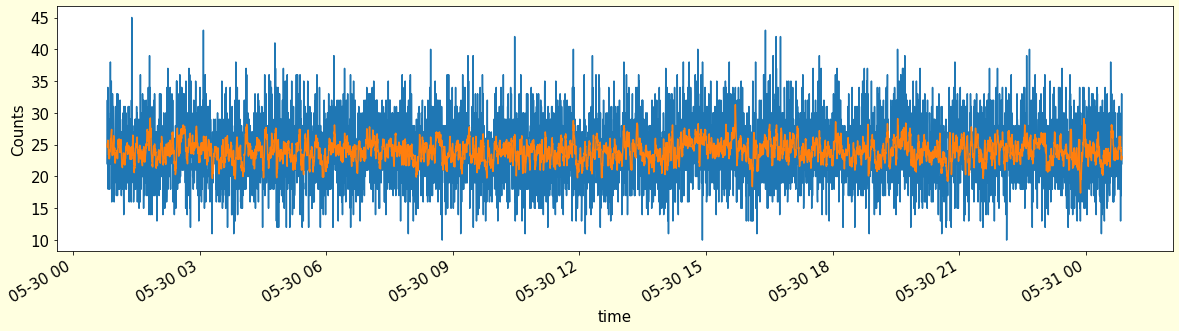

In [478]:
histogram['flux'] = histogram.loc[:,0:1023].sum(axis=1)

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

histogram['roll'] = histogram['flux'].rolling(10).mean()

plt.ylabel('Counts')

histogram['flux'].plot()
histogram['roll'].plot()

## Plot Energy

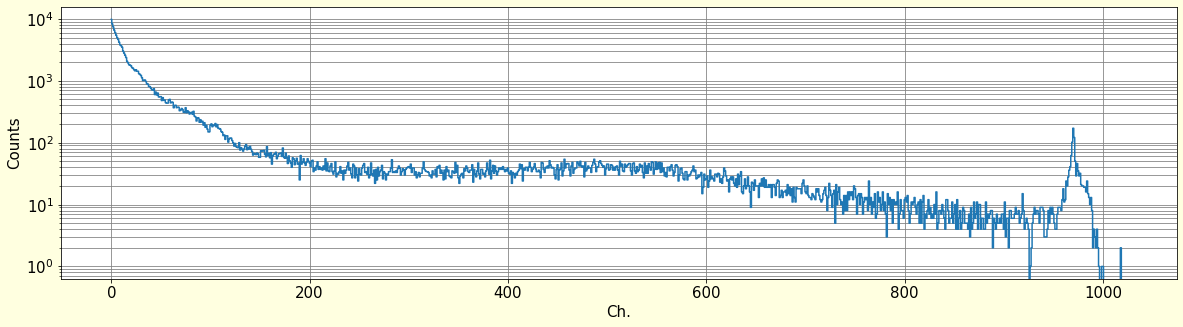

In [479]:
yy = histogram.copy()
#yy = yy.loc['2023-03-27 11:00:00':'2023-03-27 13:00:00']
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(which='minor', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([90,150])


## Plot Detail

/tmp/ipykernel_20039/1797482239.py:11: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  histogram.loc[FROM:TO,'flux'].plot()
/tmp/ipykernel_20039/1797482239.py:12: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  histogram.loc[FROM:TO,'roll'].plot()


<AxesSubplot:xlabel='time'>

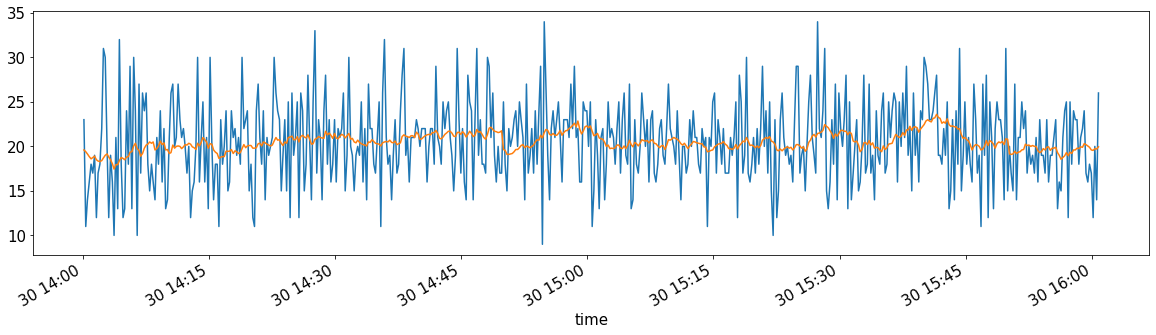

In [481]:
FROM = '2023-05-30 14:00'
TO = '2023-05-30 16:00'
#FROM = '2023-05-30 9:00'
#TO = '2023-05-30 11:00'
histogram['flux'] = histogram.loc[:,0:100].sum(axis=1)
#histogram['flux'] = histogram.loc[:,24:26].sum(axis=1)
histogram['roll'] = histogram['flux'].rolling(20).mean()
plt.figure(figsize=(20,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})
histogram.loc[FROM:TO,'flux'].plot()
histogram.loc[FROM:TO,'roll'].plot()

/tmp/ipykernel_20039/4200466924.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc[FROM:TO]


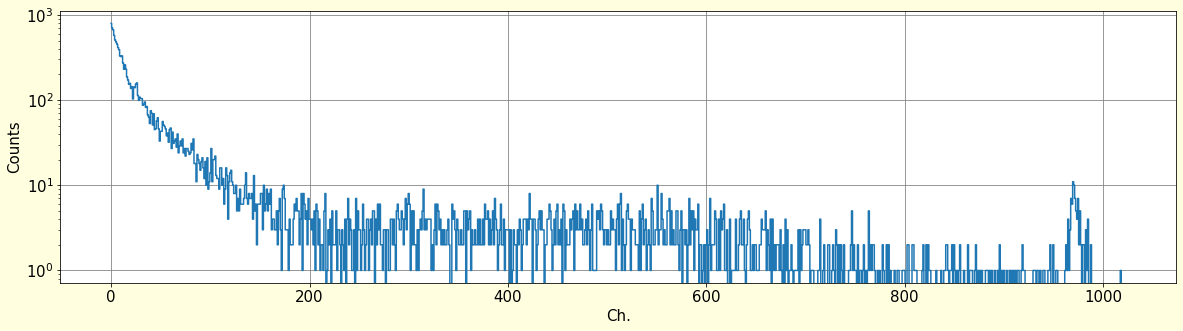

In [482]:
yy = histogram.copy()
yy = yy.loc[FROM:TO]
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([10,100])

In [126]:
yy1 = histogram.copy()
#yy = histogram.copy()


/tmp/ipykernel_20039/59152995.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = histogram.loc[FROM:TO].copy()
/tmp/ipykernel_20039/59152995.py:7: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy1 = histogram.loc[FROM1:TO1].copy()


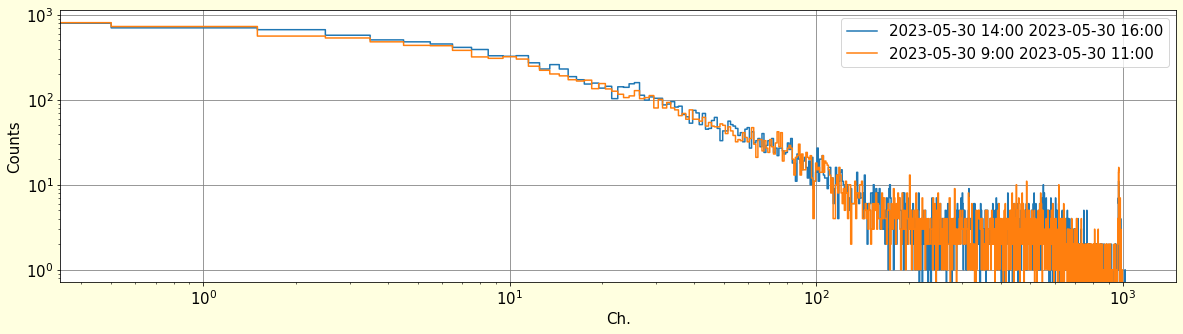

In [483]:
FROM = '2023-05-30 14:00 '
TO = '2023-05-30 16:00'
FROM1 = '2023-05-30 9:00 '
TO1 = '2023-05-30 11:00'

yy = histogram.loc[FROM:TO].copy()
yy1 = histogram.loc[FROM1:TO1].copy()
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()
ener1 = yy1.iloc[:,0:1024].sum()
ener1 = ener1.reset_index()

plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

plt.plot(ener[0], drawstyle='steps-mid', label=FROM + TO)
plt.plot(ener1[0], drawstyle='steps-mid', label=FROM1 + TO1)
#plt.plot(ener[0]/ener1[0], drawstyle='steps-mid', label=FROM1 + TO1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
plt.legend()
#plt.xlim([0,300])

In [174]:
histogram.loc[:,23:26]

,23,24,25,26
time,,,,
2023-05-30 22:50:45,0.0,0.0,0.0,0.0
2023-05-30 22:50:57,1.0,0.0,0.0,0.0
2023-05-30 22:51:10,1.0,0.0,0.0,0.0
2023-05-30 22:51:22,0.0,0.0,0.0,1.0
2023-05-30 22:51:35,0.0,0.0,0.0,0.0
...,...,...,...,...
2023-05-30 13:48:58,0.0,0.0,0.0,0.0
2023-05-30 13:49:10,0.0,0.0,0.0,0.0
2023-05-30 13:49:23,0.0,1.0,0.0,1.0


/tmp/ipykernel_20039/2093455545.py:7: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc[FROM:TO]


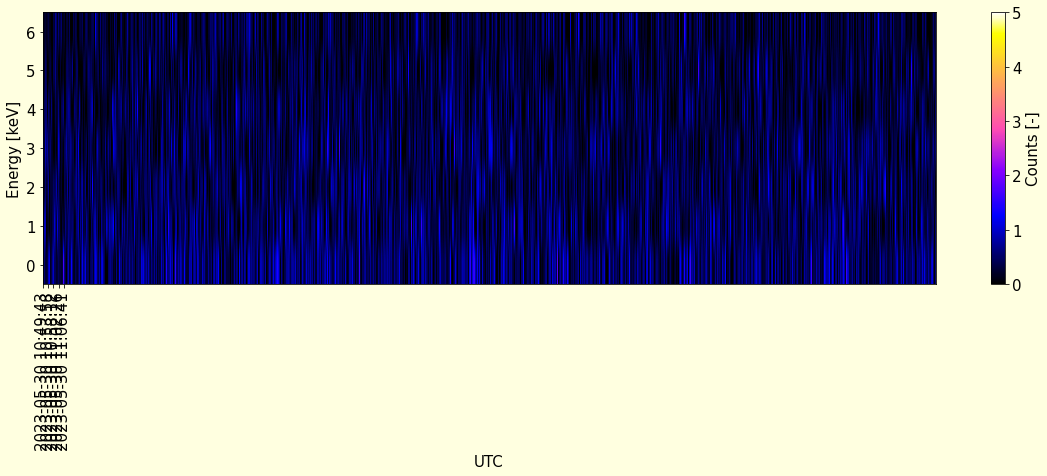

In [32]:
yy = histogram.copy()
#yy.set_index('UTC', inplace = True, drop=False)

FROM = '2023-05-30 10:00'
TO = '2023-05-30 22:00'

yy = yy.loc[FROM:TO]
plt.figure(figsize=(20,5), facecolor='lightyellow')

#orig_map=plt.cm.get_cmap('gnuplot2')
#reversed_map = orig_map.reversed()

plt.imshow( yy.iloc[:,11:18].T, aspect='auto', origin='lower', cmap = 'gnuplot2')#, norm=colors.LogNorm()) # , cmap = 'autumn') 
plt.ylabel('Energy [keV]')
plt.xlabel('UTC')
plt.colorbar(label='Counts [-]')
x1 = [0,20,40,60,80]
squad = [str(yy.iloc[0].time.round(freq='S')),str(yy.iloc[20].time.round(freq='S')),str(yy.iloc[40].time.round(freq='S')),str(yy.iloc[60].time.round(freq='S')),str(yy.iloc[80].time.round(freq='S'))]
plt.xticks(x1, squad, rotation=90)

'''
y1 = list(range(0,7))
y2 = ['']*7
for i in range(len(y1)):  
    y2[i] = str(round(113.2*y1[i]+473.46))
plt.yticks(y1, y2, rotation=0)
'''
None


In [40]:
events = pd.DataFrame(columns=['time', 'energy'])


try:
    for i in range(len(hits)):
        for j in range(hits.iloc[i,1]):
            event_ch = hits.iloc[i,j*2+3]
            event_time = hits.iloc[i,j*2+2]
            #etime = hist.iloc[i].UTC - pd.Timedelta(microseconds=64*(65535*4-event_time))
            etime = hits.iloc[i].UTC - pd.Timedelta(microseconds=54*65535*4) + pd.Timedelta(microseconds=53*event_time)
            events = pd.concat([events, pd.DataFrame.from_records([{'time':etime, 'energy':event_ch}])])

except:
    print(i,j)
    raise
            
events.set_index('time', drop=False, inplace=True)
events.sort_index(inplace=True)

0 15


TypeError: 'str' object cannot be interpreted as an integer

In [39]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 20

xx = histogram

FROM = '2023-05-30 10:00'
TO = '2023-05-30 22:00'

xx = xx.loc[FROM:TO].copy()
#blitz_x = blitz.loc[FROM:TO].copy()
events_x = events.loc[FROM:TO].copy()

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

fig, (ax6, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15,8), facecolor='lightyellow')
ax5_twin = ax6.twinx()

ax5_twin.plot(xx['flux'], c='gray', linestyle='-', marker='.', label='GEODOS (≤ Ch. 8)', drawstyle='steps-pre')
#ax5_twin.plot(xx['flux'], c='gray', label='GEODOS')
#ax5_twin.plot(xx['fluxmean'], c='gray', label='Geodos avg')
ax5_twin.set_ylabel('Counts [-]', color='black')
#ax5.set_ylim(0,21)
ax5_twin.legend()
#ax5.set_yscale('log')
#ax5_twin.grid()
#ax5.set_xlabel('UTC')

'''
ax6.plot(blitz_x.date, blitz_x.km, ls='', marker='$🗲$', label='Blitzortung')
ax6.set_ylabel('Distance [km]', color='darkblue')
ax6.set_ylim(0,65)
ax6.grid()
#ax6.vlines(x=gps_x['timeR'], ymin=0, ymax=150, color='red', label='Trigger', lw=1, alpha=0.5)
ax6.legend(loc=9)
'''
#ax2.plot(events_x.loc[events_x.energy>0].energy, ls='', ms=10, marker='+', color='green', label='> Ch. 30')
ax2.plot(events_x.energy, ls='', ms=10, marker='o', color='green', label='GEODOS (> Ch. 8)', alpha=0.1)
ax2.set_ylabel('Channel [-]', color='green')
ax2.grid()
#ax2.set_ylim(7,40)
ax2.legend(loc=1)
ax2.set_xlabel('UTC')
ax2.tick_params(axis='x', labelrotation = 90)


/tmp/ipykernel_20039/2270225869.py:10: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  xx = xx.loc[FROM:TO].copy()


NameError: name 'events' is not defined

In [28]:
yy

,0,1,2,3,4,5,6,7,8,9,...,1097,1098,1099,temperature,pressure,voltage,current,time,flux,roll
time,,,,,,,,,,,,,,,,,,,,,
2023-05-30 22:50:45,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,15.69,743.28,4.16,-55.0,2023-05-30 22:50:45,12.0,NaN
2023-05-30 22:50:57,3.0,2.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,15.63,743.28,4.16,-55.0,2023-05-30 22:50:57,22.0,NaN
2023-05-30 22:51:10,1.0,3.0,2.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,15.69,743.28,4.16,-55.0,2023-05-30 22:51:10,25.0,NaN
2023-05-30 22:51:22,2.0,2.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,15.69,743.29,4.16,-55.0,2023-05-30 22:51:22,21.0,NaN
2023-05-30 22:51:35,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,15.69,743.27,4.16,-55.0,2023-05-30 22:51:35,20.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-30 13:48:58,2.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,17.00,742.32,4.15,-58.0,2023-05-30 13:48:58,17.0,19.4
2023-05-30 13:49:10,0.0,3.0,1.0,1.0,2.0,1.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,17.00,742.33,4.15,-58.0,2023-05-30 13:49:10,16.0,18.9
2023-05-30 13:49:23,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,17.00,742.32,4.14,-60.0,2023-05-30 13:49:23,19.0,19.3


# Telemetry Plot

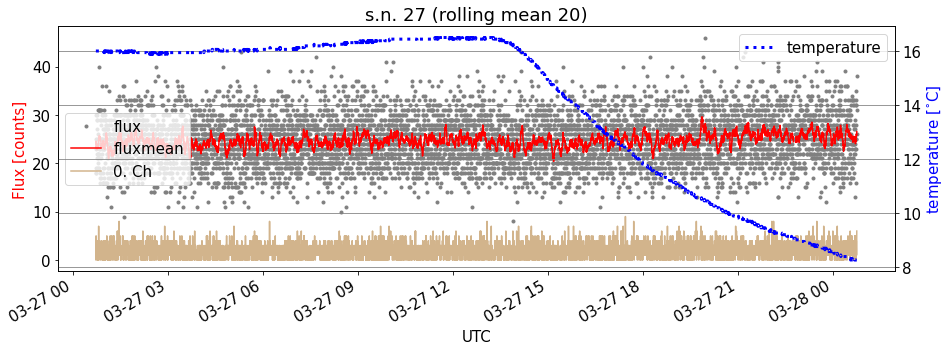

In [174]:
NOISE_LEVEL = 0
LAST_CHANNEL = 1024
WINDOW = 20

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('time', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00'] # bourka s odpalenu dobijeci eletronikou

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()



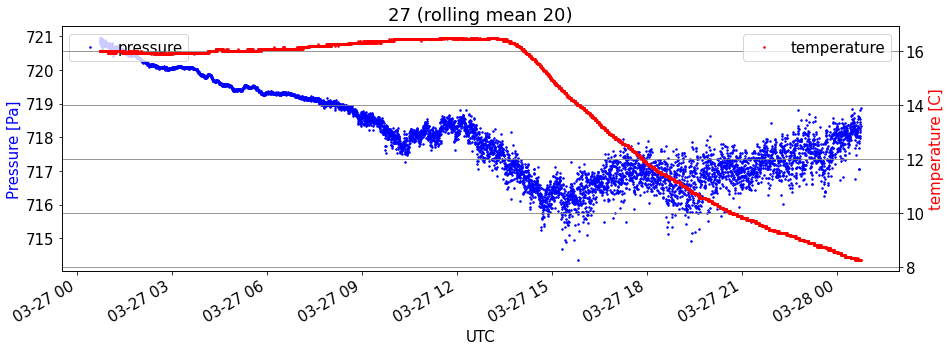

In [171]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('time', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx['pressure'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()



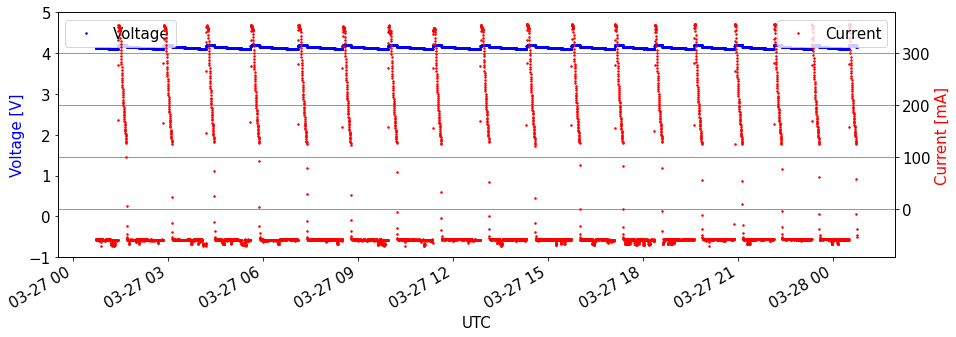

In [173]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('time', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 00:00:00':'2021-08-16 00:00:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']



xx['voltage'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'Voltage')

s = fto.split('/')
#plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([-1,5])
plt.xlabel('UTC')
plt.ylabel(r'Voltage [V]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['current'].plot(c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('Current [mA]', color='red')

plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')
plt.legend()



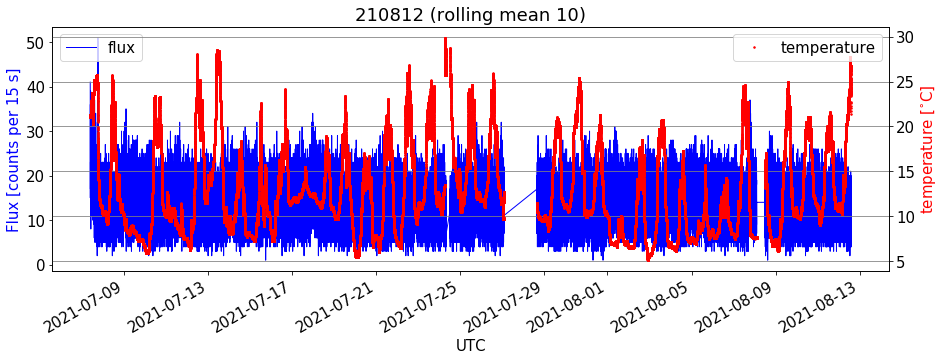

In [22]:
NOISE_LEVEL = 0
LAST_CHANNEL = 240
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='blue', linewidth=1)
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts per 15 s]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



# Blitzortung

In [15]:
lat=49.0640992 # Polednik
lon=13.3950208

#lat=49.05367 # Prvni strom
#lon=13.40039

#start=pd.Timestamp('2021-08-15 12:00') # bourke kdy odesla dobijeci elektronika
#end=pd.Timestamp('2021-08-16 18:00')

start=pd.Timestamp('2021-07-08 00:00') # bourka kdy odesla dobijeci elektronika
end=pd.Timestamp('2021-08-13 00:00')

BLITZ_DIST = 60

print(start, end, lat, lon)
region=1

### url for json data preparation
url=[]

for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html,lines=True)
        blitz_part.drop(columns=['status','sig','mds','mcg'], inplace=True)#,'region', 
        blitz=blitz.append(blitz_part)
    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
#blitz.reset_index(inplace=True)
#blitz.set_index('date', inplace=True)

blitz.to_csv(dto + "/blitz.csv")

print('end')

2021-07-08 00:00:00 2021-08-13 00:00:00 49.0640992 13.3950208
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/20.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/30.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/40.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/19/50.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/00.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/10.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/20.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/30.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/40.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/20/50.json
No data http://data.blitzortung.org/Data/Restricted/Strikes_1/2021/08/11/21/00.json
No data http:/

In [16]:
blitz

,time,lat,lon,km,date
date,,,,,
2021-07-08 00:48:30.829185439,1625705310829185439,48.632866,13.240356,49.322458,2021-07-08 00:48:30.829185439
2021-07-08 00:48:30.831775957,1625705310831775957,48.653590,13.260290,46.749865,2021-07-08 00:48:30.831775957
2021-07-08 00:48:30.831781386,1625705310831781386,48.652350,13.263133,46.841445,2021-07-08 00:48:30.831781386
2021-07-08 00:48:30.831782609,1625705310831782609,48.643393,13.253908,47.958762,2021-07-08 00:48:30.831782609
2021-07-08 11:56:00.228902204,1625745360228902204,48.957762,12.619286,57.863355,2021-07-08 11:56:00.228902204
...,...,...,...,...,...
2021-08-08 14:43:05.345944478,1628433785345944478,49.431200,13.125008,45.330898,2021-08-08 14:43:05.345944478
2021-08-08 14:43:05.345913004,1628433785345913004,49.539735,13.026111,59.332627,2021-08-08 14:43:05.345913004
2021-08-08 14:43:05.345945476,1628433785345945476,49.439992,13.117333,46.453850,2021-08-08 14:43:05.345945476


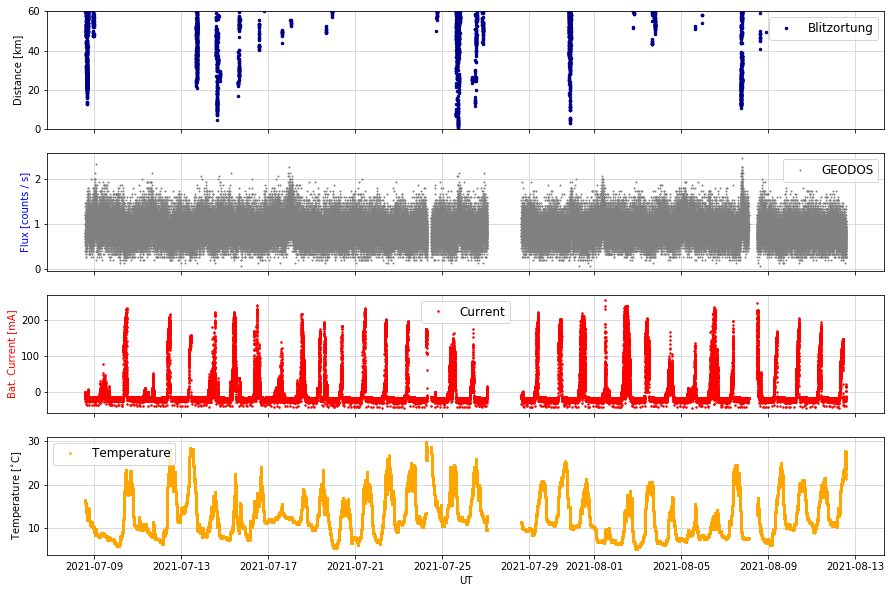

In [30]:
WINDOW = 2

blitz = pd.read_csv(dto + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax5, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

FROM = '2021-07-08 14:00:00'
TO = '2021-08-16 18:15:00'
#FROM = '2021-08-15 12:00:00'
#TO = '2021-08-16 18:00:00'
#FROM = '2021-08-15 18:00:00'
#TO = '2021-08-15 19:00:00'
#FROM = '2021-08-16 9:00:00'
#TO = '2021-08-16 12:00:00'

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-15 18:00:00':'2021-08-15 19:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-16 9:00:00':'2021-08-16 12:00:00'] # bourka s odpalenou elektronikou
#xx = xx.loc['2021-08-15 18:00:00':'2021-08-16 18:15:00']



xx = xx.loc[FROM:TO]
lightning = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=2, linestyle='none')
#ax3.plot(xx['fluxmean']/15, label='mean')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]', color='blue')
#ax3.set_yscale('log')
#ax3.set_ylim(.6,2.5)
ax3.legend(loc=1)


ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(lightning.index, lightning.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


In [20]:
xx

,0,1,2,3,4,5,6,7,8,9,...,lat,lon,date,UTC,temperature,pressure,voltage,current,flux,fluxmean
UTC,,,,,,,,,,,,,,,,,,,,,
2021-08-15 18:00:06.550,2.0,3,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:06.550,16.94,86737.50,4.08,-65,12.0,NaN
2021-08-15 18:00:22.420,5.0,3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:22.420,16.88,86747.50,4.08,-65,14.0,13.0
2021-08-15 18:00:38.600,4.0,4,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:38.600,16.88,86737.75,4.08,-65,15.0,14.5
2021-08-15 18:00:54.770,2.0,1,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:00:54.770,16.81,86754.75,4.08,-65,10.0,12.5
2021-08-15 18:01:10.960,1.0,3,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:01:10.960,16.81,86747.50,4.08,-65,11.0,10.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-15 18:58:48.140,3.0,3,2.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:58:48.140,15.81,86661.75,-0.26,-257,20.0,16.0
2021-08-15 18:59:04.300,3.0,2,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:59:04.300,15.81,86654.75,-0.26,-257,14.0,17.0
2021-08-15 18:59:20.470,3.0,6,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,49.064126,13.395212,1.629049e+18,2021-08-15 18:59:20.470,15.88,86653.00,-0.26,-257,17.0,15.5


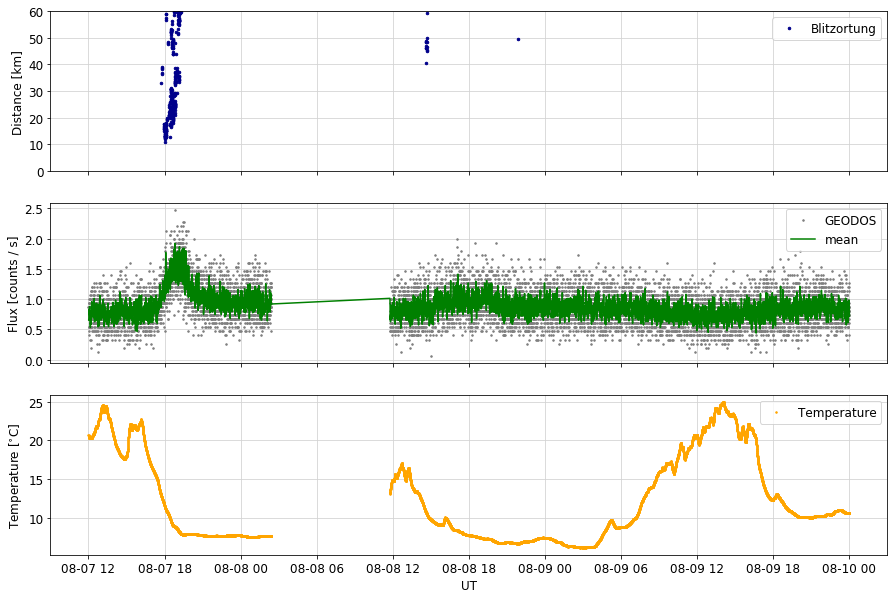

In [72]:
WINDOW = 5

blitz = pd.read_csv(dto + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax4) = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

FROM = '2021-07-08 12:00:00'
TO = '2021-08-16 18:15:00'
#FROM = '2021-07-30 12:00:00'
#TO = '2021-08-2 12:00:00'
FROM = '2021-08-7 12:00:00'
TO = '2021-08-10 00:00:00'
#FROM = '2021-07-25 12:00:00'
#TO = '2021-07-26 12:00:00'

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
xx = xx.loc[FROM:TO]
lightning = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=3, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean', color='green')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]')
#ax3.set_yscale('log')
#ax3.set_ylim(.5,2.2)
ax3.legend()
#ax3.set_xlabel('UT')

ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(lightning.index, lightning.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


# Energy Spectrum

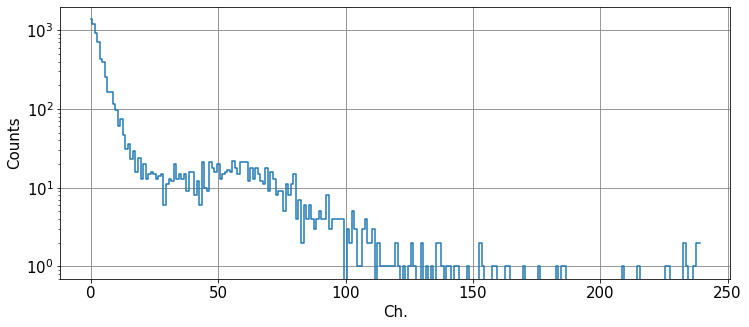

In [41]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)
#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:240].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([10,100])

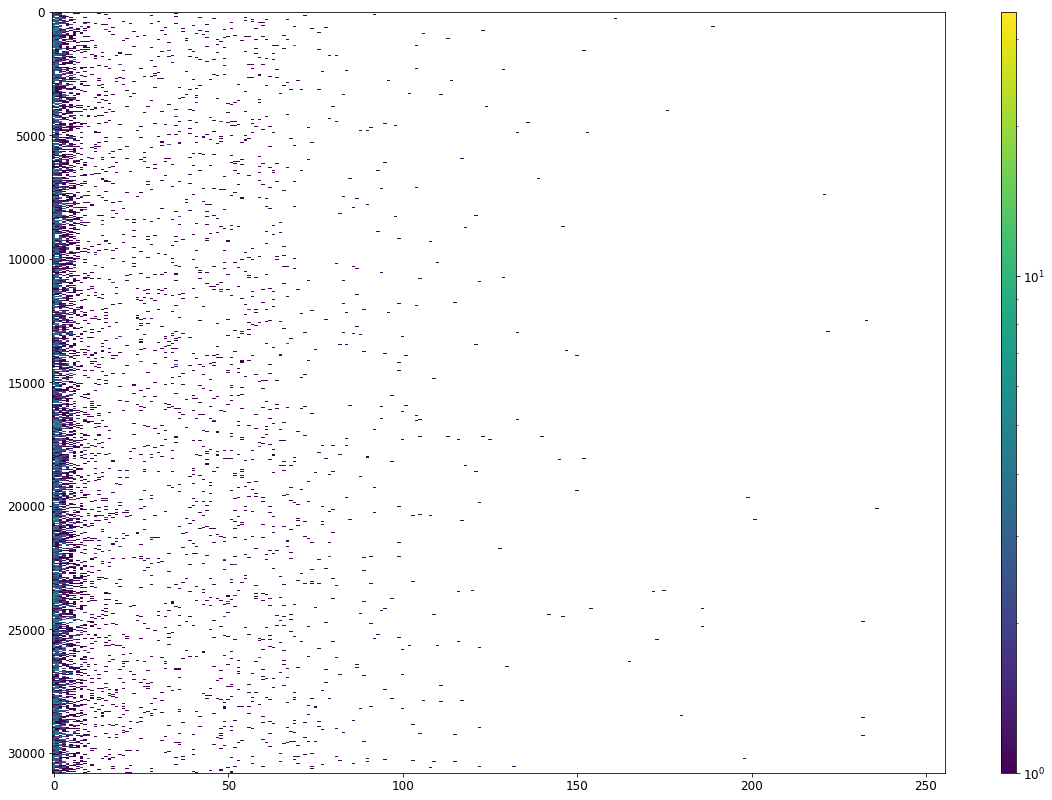

In [33]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((histogram.iloc[:,0:256]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None

## Resetitko LS

In [86]:
dto = '/storage/stations/LS/resetitko/2023/03/27/'

df = pd.DataFrame()
  
for fto in glob.iglob(dto + '*'): # generator, search immediate subdirectories 
    print(fto)
    l=[]
    l.extend(range(0,100))
    #rdf = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='c')
    rdf = pd.read_table(fto, sep=',', header=None, comment='*',engine='c')
    df = pd.concat([df, rdf])
    
    
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)


/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_16
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_05
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_08
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_02
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_23
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_11
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_15
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_06
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_01
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_20
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_18
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_12
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_22
/storage/stations/LS/resetitko/2023/03/27/resetitko.csv.2023-03-27_10
/storage/stations/LS

In [87]:
df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,1679935084,$CANDY,57741,628546,52100,0,254,0,9454,27098,...,0,0,0,0,0,0,0,0,0,0
1,1679935095,$CANDY,57742,628557,52088,0,254,0,9588,26850,...,0,0,0,0,0,0,0,0,0,0
2,1679935105,$CANDY,57743,628568,52140,1,254,0,9461,26892,...,0,0,0,0,0,0,0,0,0,0
3,1679935116,$CANDY,57744,628579,52140,0,255,0,9435,26980,...,0,0,0,0,0,0,0,0,0,0
4,1679935127,$CANDY,57745,628589,52079,0,255,0,9605,26793,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,1679931426,$CANDY,57405,624888,51997,1,253,0,9253,27072,...,0,0,0,0,0,0,0,0,0,0
327,1679931437,$CANDY,57406,624899,52057,1,254,0,8993,27335,...,0,0,0,0,0,0,0,0,0,0
328,1679931448,$CANDY,57407,624910,52033,1,255,0,8907,27383,...,0,0,0,0,0,0,0,0,0,0
329,1679931459,$CANDY,57408,624921,52045,3,254,0,9134,27220,...,0,0,0,0,0,0,0,0,0,0


In [96]:
hist = df.loc[df[1]=='$CANDY'].iloc[:,12:]
hist['time'] = df.loc[df[1]=='$CANDY'].iloc[:,0]
hist['time'] = pd.to_datetime(hist['time'], unit='s')
hist.set_index('time', drop=False, inplace=True)
hist['flux'] = hist.loc[:,17:36].sum(axis=1)


<AxesSubplot:xlabel='time', ylabel='Counts'>

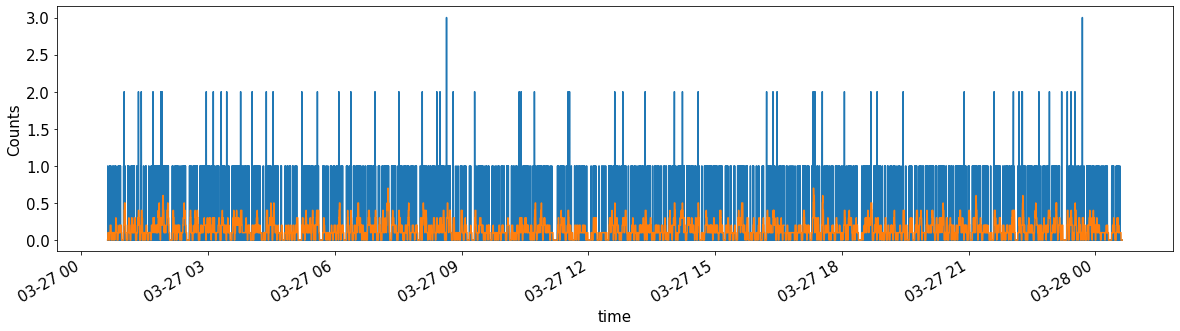

In [98]:
plt.figure(figsize=(20,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

hist['roll'] = hist['flux'].rolling(10).mean()

plt.ylabel('Counts')

hist['flux'].plot()
hist['roll'].plot()

/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_21
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_19
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_13
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_00
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_07
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_14
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_22
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_10
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_09
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_03
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_04
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_17
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_15
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_06
/storage/stations/LS/vezicka/efm_down/efm_down.csv.2023-05-30_01
/storage/stations/LS/vezi

/tmp/ipykernel_20039/2984582821.py:50: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  histogram.loc[FROM:TO,'flux'].plot(alpha=0.5,color='lightgray')
/tmp/ipykernel_20039/2984582821.py:51: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  histogram.loc[FROM:TO,'roll'].plot(alpha=0.5,color='orange')


Text(0, 0.5, 'Counts [-]')

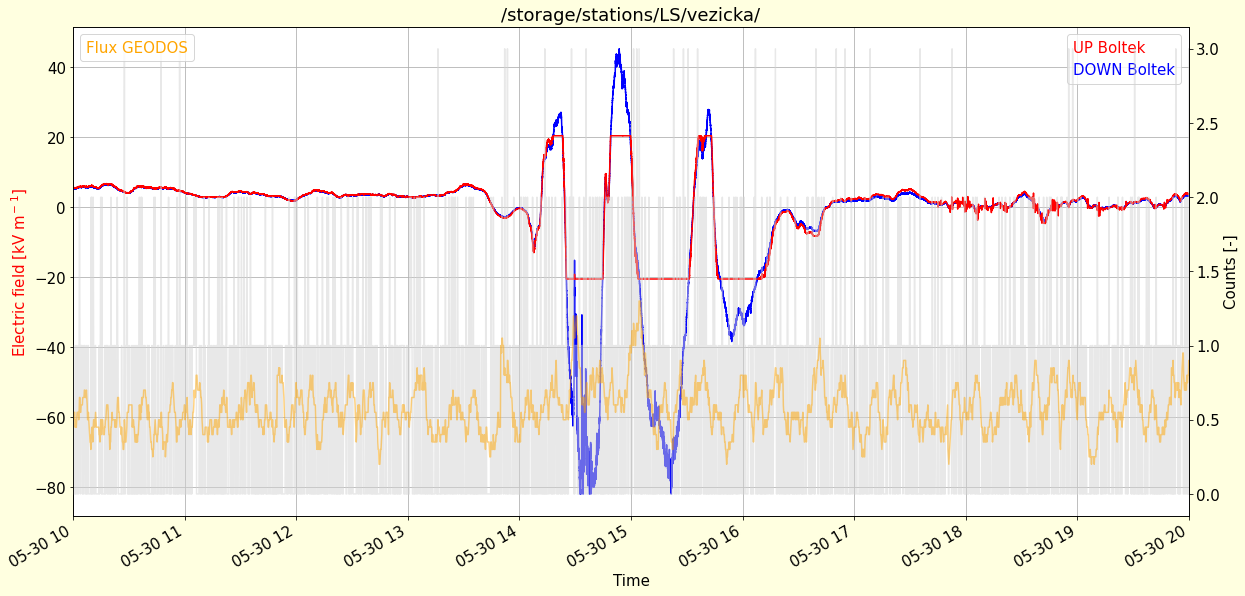

In [241]:
fto = '/storage/stations/LS/vezicka/'

ftt = glob.iglob(fto+"/**/*.csv.2023-05-30*") # generator, search immediate subdirectories 

plt.figure(figsize=(20,10), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})

for f in ftt:
    print(f)
    l=[]
    l.extend(range(0,4))
    
    df = pd.read_csv(f, sep=',', header=None, names=l, comment='*', low_memory=False, on_bad_lines='skip')

    if 'up' in f:
        label = 'UP Boltek'
        color = 'red'
        factor = 1
    else:
        label = 'DOWN Boltek'
        color = 'blue'
        factor = 4
   
    
    df['field'] = df[1].str.replace('$', '', regex=False)
    df['time'] = pd.to_datetime(df[0],unit='s')
    df.set_index('time', inplace=True, drop=False)
    df['field'] = pd.to_numeric(df['field'])
    
    (df['field']*factor).plot(label=label, color=color)

plt.ylabel('Electric field [kV m$^-$$^1$]', color='red')
plt.title(fto)
#plt.legend()
plt.legend(['UP Boltek','DOWN Boltek'], labelcolor=['red','blue'], handlelength=0, handletextpad=0, fancybox=True) 
#plt.legend(['DOWN'], labelcolor=['blue'], handlelength=0, handletextpad=0, fancybox=True) 
plt.grid()
plt.xlabel('Time')
#plt.ylim(-20,20)
#plt.xlim('2023-05-30 10:00','2023-05-30 22:00')
plt.xlim('2023-05-30 10:00','2023-05-30 20:00')

plt.twinx()

FROM = '2023-05-30 10:00'
TO = '2023-05-30 22:00'
histogram['flux'] = histogram.loc[:,25:27].sum(axis=1)
histogram['roll'] = histogram['flux'].rolling(20).mean()
matplotlib.rcParams.update({'font.size': 15})
histogram.loc[FROM:TO,'flux'].plot(alpha=0.5,color='lightgray')
histogram.loc[FROM:TO,'roll'].plot(alpha=0.5,color='orange')
plt.legend(['Flux GEODOS'], labelcolor=['orange'], handlelength=0, handletextpad=0, fancybox=True, loc=2) 
plt.ylabel('Counts [-]')


In [54]:
hits

,0,1,2,3,4,5,6,7,8,9,...,1030,1031,1032,1033,1034,1035,1036,1037,1038,time
1,1685487045,$HITS,6,5298.0,76.0,31033.0,207.0,35494.0,129.0,59096.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 22:50:45
3,1685487057,$HITS,8,20176.0,576.0,27467.0,38.0,30848.0,374.0,42206.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 22:50:57
5,1685487070,$HITS,8,21848.0,66.0,33892.0,57.0,38210.0,486.0,43320.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 22:51:10
7,1685487083,$HITS,15,22765.0,38.0,23524.0,39.0,27506.0,52.0,30000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 22:51:23
9,1685487095,$HITS,18,770.0,203.0,1185.0,289.0,3928.0,33.0,3954.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 22:51:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,1685454538,$HITS,11,17570.0,33.0,19275.0,525.0,20740.0,69.0,24872.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 13:48:58
563,1685454551,$HITS,5,25000.0,378.0,25207.0,104.0,50278.0,458.0,78324.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 13:49:11
565,1685454563,$HITS,11,19413.0,29.0,25532.0,33.0,39923.0,41.0,44702.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 13:49:23
567,1685454576,$HITS,10,1351.0,41.0,2357.0,754.0,9284.0,314.0,9521.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-05-30 13:49:36
